In [1]:
%pip install ultralytics==8.0.196

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO
from IPython.display import display, Image

Ultralytics YOLOv8.0.196  Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Setup complete  (8 CPUs, 15.8 GB RAM, 411.6/458.8 GB disk)


In [3]:
import torch
import cv2
import numpy as np

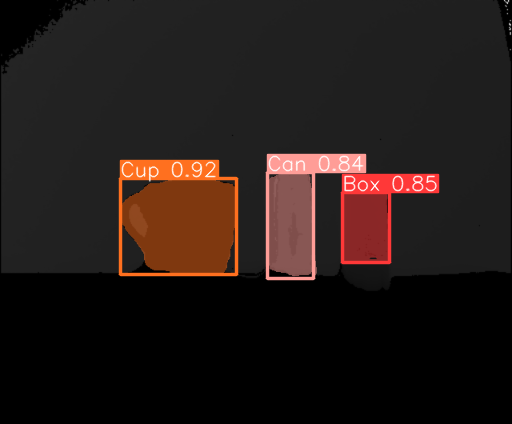

In [6]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'runs/segment/predict/*.png'):
      display(Image(filename=image_path, height=600))
      print("\n")

In [4]:
depth_img_path = './test_set/0025_depth.png'

In [5]:
model = YOLO(f'./model/best.pt')
results = model.predict(source=depth_img_path, conf=0.25, save=True)


image 1/1 c:\7th sem project\Multiclass Segmentation\test_set\0025_depth.png: 544x640 1 Box, 1 Can, 1 Cup, 161.3ms
Speed: 10.1ms preprocess, 161.3ms inference, 39.8ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs\segment\predict4


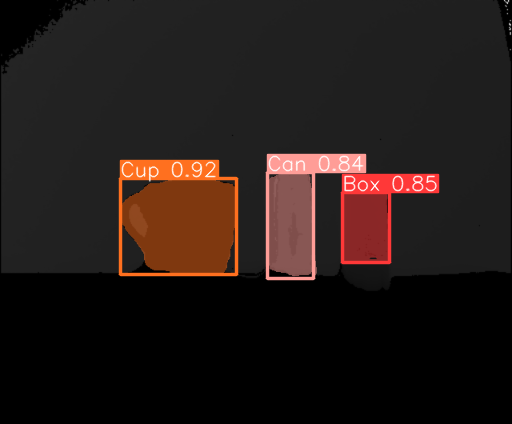

In [6]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'runs/segment/predict/*.png'):
      display(Image(filename=image_path, height=600))
      print("\n")

In [7]:

bounding_boxes = results[0].boxes.xyxy
print(bounding_boxes)
classes = results[0].boxes.cls
print(classes)

tensor([[120.8407, 178.3453, 236.1725, 274.1208],
        [342.0885, 192.7453, 389.4700, 262.2201],
        [267.3780, 172.7230, 313.8604, 278.4253]], device='cuda:0')
tensor([2., 0., 1.], device='cuda:0')


In [8]:
image = cv2.imread(depth_img_path)

class_pixel_intensities = {}

# Iterate over each object
for box, cls in zip(bounding_boxes, classes):
    # Extract coordinates
    x1, y1, x2, y2 = box.tolist()
    
    # Convert coordinates to integers
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    
    # Extract the region of interest (ROI) within the bounding box
    roi = image[y1:y2, x1:x2]
    
    # Calculate the average pixel intensity
    average_intensity = roi.mean()
    
    # Store the average pixel intensity for the current class
    if cls.item() not in class_pixel_intensities:
        class_pixel_intensities[cls.item()] = []
    class_pixel_intensities[cls.item()].append(average_intensity)

# Mapping class indices to class names
class_names = {0: "box", 1: "can", 2: "cup"}

# List to store the comparison results
comparison_results = []

# Iterate over each object
for current_class, current_intensities in class_pixel_intensities.items():
    current_class_name = class_names[current_class]
    
    # Compare the current object with all other objects
    for next_class, next_intensities in class_pixel_intensities.items():
        next_class_name = class_names[next_class]
        
        # Skip comparing the object with itself
        if current_class != next_class:
            current_intensity = sum(current_intensities) / len(current_intensities)
            next_intensity = sum(next_intensities) / len(next_intensities)
            
            if current_intensity > next_intensity:
                comparison_results.append(f"The {current_class_name} is behind the {next_class_name}.")
            else:
                comparison_results.append(f"The {current_class_name} is in front of the {next_class_name}.")

# Print the comparison results
for result in comparison_results:
    print(result)

The cup is in front of the box.
The cup is in front of the can.
The box is behind the cup.
The box is behind the can.
The can is behind the cup.
The can is in front of the box.


In [9]:

image = cv2.imread(depth_img_path)

# Dictionary to store the bounding box coordinates for each class
class_bounding_boxes = {}

# Iterate over each object
for box, cls in zip(bounding_boxes, classes):
    # Store the bounding box coordinates for the current class
    if cls.item() not in class_bounding_boxes:
        class_bounding_boxes[cls.item()] = []
    class_bounding_boxes[cls.item()].append(box.tolist())

# Mapping class indices to class names
class_names = {0: "box", 1: "can", 2: "cup"}

# List to store the comparison results
comparison_results = []

# Iterate over each object
for current_class, current_boxes in class_bounding_boxes.items():
    current_class_name = class_names[current_class]
    
    # Compare the current object with all other objects
    for next_class, next_boxes in class_bounding_boxes.items():
        next_class_name = class_names[next_class]
        
        # Skip comparing the object with itself
        if current_class != next_class:
            # Compare the current object with each box of the next object
            for current_box in current_boxes:
                for next_box in next_boxes:
                    # Extract the x-coordinate of the center of each bounding box
                    current_center_x = (current_box[0] + current_box[2]) / 2
                    next_center_x = (next_box[0] + next_box[2]) / 2
                    
                    if current_center_x < next_center_x:
                        comparison_results.append(f"The {current_class_name} is to the left of the {next_class_name}.")
                    else:
                        comparison_results.append(f"The {current_class_name} is to the right of the {next_class_name}.")

# Print the comparison results
for result in comparison_results:
    print(result)

The cup is to the left of the box.
The cup is to the left of the can.
The box is to the right of the cup.
The box is to the right of the can.
The can is to the right of the cup.
The can is to the left of the box.


In [ ]:
# class:
    # box: 0
    # can: 1
    # cup: 2

In [ ]:
# model = torch.load('best.pt')
# !yolo task=segment mode=predict model=model/best.pt conf=0.25 source=test_set save=true